In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [2]:
'''
Loading the graph with adjacency
'''

graph = src.graph.graph_from_json('Outputs/graph_full.json')
graph = src.routing.edge_types(graph)

In [3]:
for source, node in graph._node.items():

    if 'pop' in node:

        node['population'] = node['pop']
        node.pop('pop')

    if 'station' not in source:

        node['type'] = 'place'

In [5]:
'''
Removing non-corridor stations
'''
roadnums = []

for source, node in graph._node.items():
    
    roadnums.append(node['roadnum'])

unique_roadnum, unique_roadnum_count = np.unique(roadnums, return_counts = True)

roadnums_keep = unique_roadnum[(unique_roadnum_count >= 10) & (unique_roadnum != 'nan')]
roadnums_keep = np.append(roadnums_keep, 'U395')

corridor_roadnum = []

corridor_roadnum.extend([r for r in unique_roadnum if 'I' in r])
corridor_roadnum.extend([r for r in unique_roadnum if 'U' in r])
corridor_roadnum.extend(['S1', 'S41', 'S99'])

roadnums_keep = corridor_roadnum

nodes_keep = []

for source, node in graph._node.items():

    roadnum = node['roadnum']

    if node['type'] == 'place':

        nodes_keep.append(source)
    
    else:

        if roadnum in roadnums_keep:
    
            nodes_keep.append(source)

roadnums_keep = np.append(roadnums_keep, 'U395')

sng_corridor = src.graph.subgraph(graph, nodes_keep)

In [6]:
unique_roadnum

array(['C200', 'CA8', 'CG15', 'I10', 'I105', 'I110', 'I15', 'I205',
       'I210', 'I215', 'I280', 'I305', 'I40', 'I405', 'I5', 'I580',
       'I605', 'I680', 'I710', 'I8', 'I80', 'I805', 'I880', 'I980', 'S1',
       'S101 P', 'S105', 'S107', 'S108', 'S110', 'S111', 'S116', 'S118',
       'S12', 'S120', 'S121', 'S126', 'S127', 'S128', 'S130', 'S134',
       'S135', 'S138', 'S14', 'S140', 'S145', 'S150', 'S152', 'S16',
       'S160', 'S162', 'S163', 'S166', 'S168', 'S17', 'S173', 'S178',
       'S18', 'S180', 'S183', 'S185', 'S189', 'S198', 'S2', 'S20', 'S203',
       'S210', 'S22', 'S223', 'S227', 'S23', 'S238', 'S24', 'S241',
       'S246', 'S25', 'S260', 'S267', 'S28', 'S280', 'S29', 'S299', 'S3',
       'S33', 'S330', 'S36', 'S371', 'S39', 'S4', 'S41', 'S43', 'S44',
       'S46', 'S47', 'S49', 'S52', 'S54', 'S55', 'S56', 'S57', 'S58',
       'S60', 'S61', 'S62', 'S65', 'S67', 'S68', 'S70', 'S71', 'S73',
       'S74', 'S75', 'S76', 'S78', 'S79', 'S84', 'S85', 'S86', 'S87',
       'S8

In [7]:
roadnums_keep

array(['I10', 'I105', 'I110', 'I15', 'I205', 'I210', 'I215', 'I280',
       'I305', 'I40', 'I405', 'I5', 'I580', 'I605', 'I680', 'I710', 'I8',
       'I80', 'I805', 'I880', 'I980', 'U101', 'U156', 'U395', 'U50',
       'U95', 'S1', 'S41', 'S99', 'U395'], dtype='<U4')

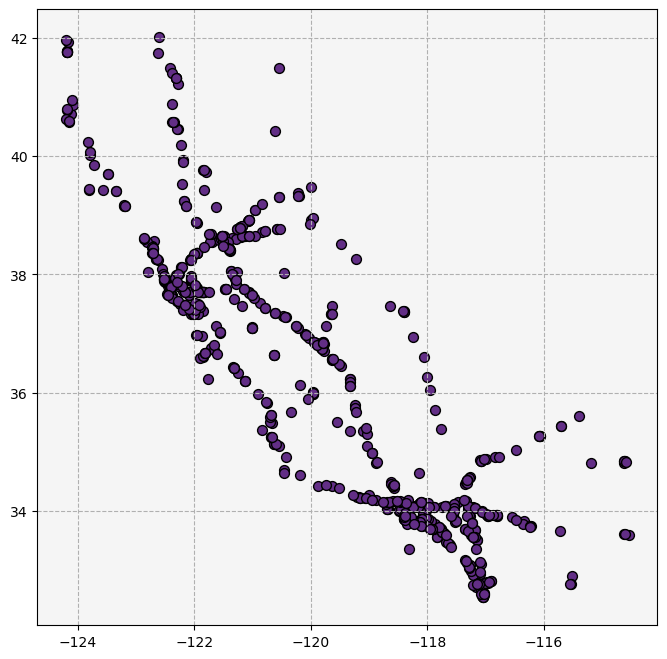

In [8]:
fig, ax = plt.subplots(figsize = (8, 8))

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 50,
        'ec': 'k',
        'fc': '#622e86',
        'zorder': 1,
        'label': 'Non-Proprietary Stations',
    },
}

src.figures.plot_graph(sng_corridor, ax = ax, **kw)

kw = {
    'fontsize': 'medium',
}   

# fig.savefig('Paper/figs/California_SNG_NP.png', bbox_inches = 'tight', dpi = 300)

In [9]:
sng_corridor.number_of_nodes(), sng_corridor.number_of_edges()

(678, 202673)

In [10]:
u, c = np.unique(
    [n.get('network', '') for n in sng_corridor._node.values()], return_counts = True
)

other_networks = u[(c >= 50) & (u != 'Tesla') & (u != 'Non-Networked')]
other_networks = u

In [11]:
'''
Creating Tesla and non-tesla SNGs
'''

tesla = []
other = []
combined = []
rivian = []

for source, node in sng_corridor._node.items():

    if node['type'] == 'place':

        tesla.append(source)
        other.append(source)
        combined.append(source)
        rivian.append(source)

    else:

        include = False

        if node['network'] == 'Tesla':

            tesla.append(source)
            combined.append(source)

        else:

            other.append(source)
            
        if node['network'] in other_networks:

            combined.append(source)

        if node['network'] in ['RIVIAN_ADVENTURE']:

            rivian.append(source)

sng_tesla = src.graph.subgraph(graph, tesla)
sng_other = src.graph.subgraph(graph, other)
sng_combined = src.graph.subgraph(graph, combined)
sng_rivian = src.graph.subgraph(graph, rivian)

In [12]:
sng_combined.number_of_nodes(), sng_tesla.number_of_nodes(), sng_other.number_of_nodes(), sng_rivian.number_of_nodes()

(678, 218, 498, 50)

In [13]:
src.graph.graph_to_json(sng_combined, 'Outputs/sng_combined.json')
src.graph.graph_to_json(sng_tesla, 'Outputs/sng_tesla.json')
src.graph.graph_to_json(sng_other, 'Outputs/sng_other.json')
src.graph.graph_to_json(sng_rivian, 'Outputs/sng_sng_rivian.json')

In [181]:
graph = src.graph.graph_from_json('Outputs/graph_empty.json')

In [212]:
summary_stats = {}

for source, node in graph._node.items():

    network = node.get('network', '')

    if network in summary_stats:

        summary_stats[network]['stations'] += 1
        summary_stats[network]['chargers'] += node.get('n_dcfc', 0)

    else:

        summary_stats[network] = {'stations': 1, 'chargers': node.get('n_dcfc', 0)}

In [213]:
summary_stats_c = {}

for source, node in sng_combined._node.items():

    network = node.get('network', '')

    if network in summary_stats_c:

        summary_stats_c[network]['stations'] += 1
        summary_stats_c[network]['chargers'] += node.get('n_dcfc', 0)

    else:

        summary_stats_c[network] = {'stations': 0, 'chargers': 0}

In [214]:
for key, value in summary_stats.items():

    if key and value['stations'] > 0:

        string = f"\\hline {key} & {value['chargers']} "
        string += f"& {value['stations']} & "
        string += f"{value['chargers'] / value['stations']:.1f} \\\\"
        
        print(string)

\hline Non-Networked & 288 & 51 & 5.6 \\
\hline Tesla & 2753 & 156 & 17.6 \\
\hline Electrify America & 526 & 77 & 6.8 \\
\hline EV Connect & 59 & 19 & 3.1 \\
\hline ChargePoint Network & 186 & 79 & 2.4 \\
\hline Volta & 2 & 2 & 1.0 \\
\hline EVCS & 41 & 11 & 3.7 \\
\hline SHELL_RECHARGE & 39 & 11 & 3.5 \\
\hline EVGATEWAY & 21 & 5 & 4.2 \\
\hline eVgo Network & 332 & 63 & 5.3 \\
\hline BP_PULSE & 3 & 2 & 1.5 \\
\hline POWERFLEX & 12 & 3 & 4.0 \\
\hline FLO & 1 & 1 & 1.0 \\
\hline EVRANGE & 11 & 3 & 3.7 \\
\hline RIVIAN_ADVENTURE & 14 & 7 & 2.0 \\
\hline CIRCLE_K & 16 & 3 & 5.3 \\
\hline CHARGENET & 7 & 1 & 7.0 \\
\hline Blink Network & 2 & 2 & 1.0 \\
\hline NOODOE & 2 & 1 & 2.0 \\
\hline LOOP & 6 & 2 & 3.0 \\
\hline 7CHARGE & 4 & 1 & 4.0 \\


In [215]:
for key, value in summary_stats_c.items():

    if key and value['stations'] > 0:

        string = f"\\hline {key} & {value['chargers']} "
        string += f"& {value['stations']} & "
        string += f"{value['chargers'] / value['stations']:.1f} \\\\"
        
        print(string)

\hline Non-Networked & 274 & 50 & 5.5 \\
\hline Tesla & 2745 & 155 & 17.7 \\
\hline Electrify America & 518 & 76 & 6.8 \\
\hline EV Connect & 58 & 18 & 3.2 \\
\hline ChargePoint Network & 184 & 78 & 2.4 \\
\hline Volta & 1 & 1 & 1.0 \\
\hline EVCS & 35 & 10 & 3.5 \\
\hline SHELL_RECHARGE & 37 & 10 & 3.7 \\
\hline EVGATEWAY & 19 & 4 & 4.8 \\
\hline eVgo Network & 329 & 62 & 5.3 \\
\hline BP_PULSE & 1 & 1 & 1.0 \\
\hline POWERFLEX & 10 & 2 & 5.0 \\
\hline EVRANGE & 5 & 2 & 2.5 \\
\hline RIVIAN_ADVENTURE & 12 & 6 & 2.0 \\
\hline CIRCLE_K & 12 & 2 & 6.0 \\
\hline Blink Network & 1 & 1 & 1.0 \\
\hline LOOP & 2 & 1 & 2.0 \\


In [186]:
graph = src.graph.subgraph(
    sng_combined,
    [k for k, v in sng_combined._node.items() if v['type'] == 'station']
)

In [187]:
un, unc = np.unique(
    [n.get('network', 'none') for n in graph._node.values()],
    return_counts = True,
)

In [188]:
un, unc

(array(['7CHARGE', 'BP_PULSE', 'Blink Network', 'CHARGENET', 'CIRCLE_K',
        'ChargePoint Network', 'EV Connect', 'EVCS', 'EVGATEWAY',
        'EVRANGE', 'Electrify America', 'FLO', 'LOOP', 'NOODOE',
        'Non-Networked', 'POWERFLEX', 'RIVIAN_ADVENTURE', 'SHELL_RECHARGE',
        'Tesla', 'Volta', 'eVgo Network'], dtype='<U19'),
 array([  1,   2,   2,   1,   3,  79,  19,  11,   5,   3,  77,   1,   2,
          1,  51,   3,   7,  11, 156,   2,  63]))

In [189]:
indices = np.flip(np.argsort(unc))
unc = unc[indices]
un = un[indices]

In [190]:
combinations = [[n] for idx, n in enumerate(un) if unc[idx] > 20]
combinations.append([n for idx, n in enumerate(un) if unc[idx] <= 20])

In [191]:
labels = [c[0] for c in combinations]
labels[-1] = 'Other Networks'

In [192]:
subgraphs = {}

for idx, label in enumerate(labels):

    comb = combinations[idx]

    nodes = [k for k, v in graph._node.items() if v.get('network', '') in comb]

    subgraphs[label] = src.graph.subgraph(graph, nodes)

In [193]:
combinations

[['Tesla'],
 ['ChargePoint Network'],
 ['Electrify America'],
 ['eVgo Network'],
 ['Non-Networked'],
 ['EV Connect',
  'EVCS',
  'SHELL_RECHARGE',
  'RIVIAN_ADVENTURE',
  'EVGATEWAY',
  'EVRANGE',
  'POWERFLEX',
  'CIRCLE_K',
  'Volta',
  'LOOP',
  'Blink Network',
  'BP_PULSE',
  'FLO',
  'NOODOE',
  'CHARGENET',
  '7CHARGE']]

In [194]:
x = []
n = []
h = []

for idx, combination in enumerate(combinations):

    print(combination)

    x_i, n_i, h_i = src.analysis.redundancy_in_station(subgraphs[labels[idx]])
    
    x.append(x_i)
    n.append(n_i)
    h.append(h_i)

['Tesla']
['ChargePoint Network']
['Electrify America']
['eVgo Network']
['Non-Networked']
['EV Connect', 'EVCS', 'SHELL_RECHARGE', 'RIVIAN_ADVENTURE', 'EVGATEWAY', 'EVRANGE', 'POWERFLEX', 'CIRCLE_K', 'Volta', 'LOOP', 'Blink Network', 'BP_PULSE', 'FLO', 'NOODOE', 'CHARGENET', '7CHARGE']


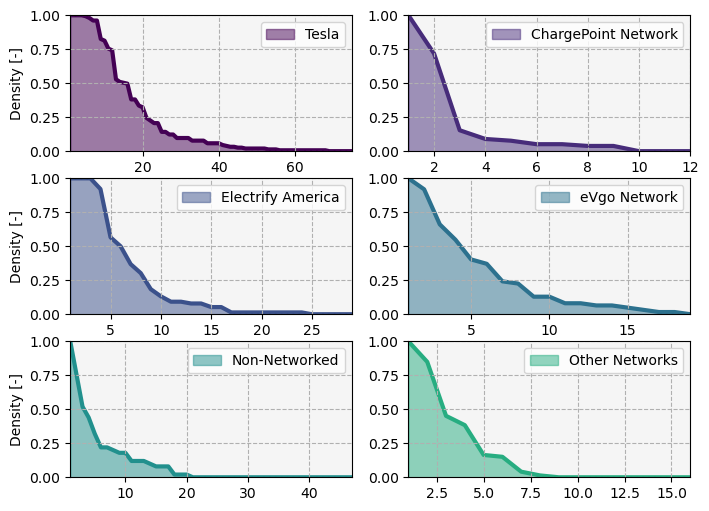

In [195]:
m = 8
rows = 3
columns = 2

cmap = src.figures.colormap('viridis')

fig, ax = plt.subplots(rows, columns, figsize = (4 * columns, 2 * rows))

idx = 0
for r in range(rows):
    for c in range(columns):

        color = cmap(idx / m * .999)

        kw = {
            'color': color,
            'zorder': 1,
            'lw': 3,
        }
        
        ax[r, c].plot(x[idx], h[idx].sf(x[idx]), **kw)
        
        kw = {
            'color': color,
            'zorder': 0,
            'alpha': .5,
            'label': labels[idx]
        }
        
        ax[r, c].fill_between(x[idx], 0, h[idx].sf(x[idx]), **kw)

        xlabel = None
        ylabel = None
        
        if r == 3:
            xlabel = 'Network In-Station Redundancy [ports]'

        if c == 0:
            ylabel = 'Density [-]'
        
        kw = {
            'xlim': [x[idx][0], x[idx][-1]],
            'ylim': [0, 1],
            'xlabel': xlabel,
            'ylabel': ylabel,
            'facecolor': 'whitesmoke',
        }
        
        ax[r, c].set(**kw)
        
        kw = {
            'ls': '--',
        }
        
        ax[r, c].grid(**kw)
        
        ax[r, c].legend()

        idx += 1

fig.savefig('Paper/figs/California_RIS_SF_Corridor.png', bbox_inches = 'tight', dpi = 300)

In [15]:
outline = gpd.read_file('Data/State/tl_2023_us_state.shp')

In [16]:
atlas = src.graph.graph_from_json('atlas.json')

In [198]:
cities = src.graph.graph_from_json('cities.json')

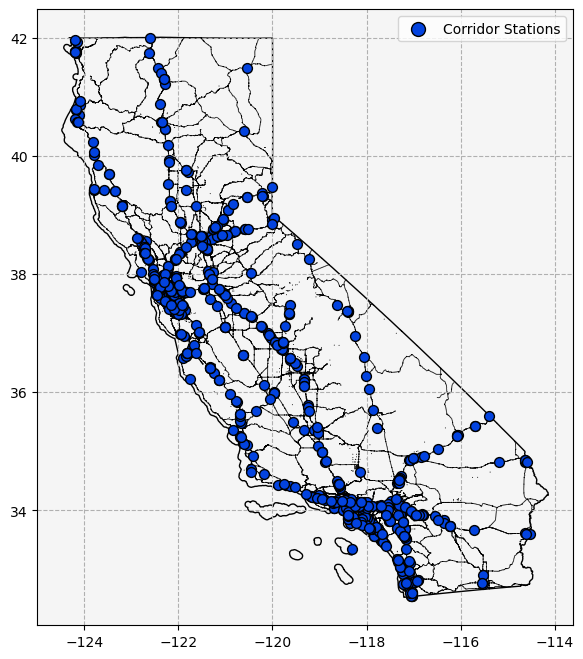

In [17]:
fig, ax = plt.subplots(figsize = (8, 8))

outline[outline['STATEFP'] == '06'].plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'show_links': False,
    'scatter': {
        's': .5,
        'ec': 'none',
        'fc': 'k',
        'zorder': 0,
    },
}

src.figures.plot_graph(atlas, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 50,
        'ec': 'k',
        'fc': 'xkcd:blue',
        'zorder': 2,
        'label': 'Corridor Stations',
    },
}

src.figures.plot_graph(sng_corridor, ax = ax, **kw)

kw = {
    'fontsize': 'medium',
}
    

legend = ax.legend(**kw)

for h in legend.legendHandles:
    h._sizes = [100]
    

fig.savefig('Paper/figs/California_SNG_Corridor.png', bbox_inches = 'tight', dpi = 300)